In [24]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv(r"C:\Users\Owner\Downloads\atlas_z_to_ll.csv")

# Define helper functions
def calculate_components(pt, eta, phi):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    return px, py, pz

def calculate_invariant_mass(E, px, py, pz):
    return np.sqrt(np.maximum(E**2 - (px**2 + py**2 + pz**2), 0))

# Compute individual momentum components
px1, py1, pz1 = calculate_components(df['pt1'], df['eta1'], df['phi1'])
px2, py2, pz2 = calculate_components(df['pt2'], df['eta2'], df['phi2'])

# Total four-momentum
E_total = df['E1'] + df['E2']
px_total = px1 + px2
py_total = py1 + py2
pz_total = pz1 + pz2

# Calculate invariant mass
df['invariant_mass'] = calculate_invariant_mass(E_total, px_total, py_total, pz_total)

# Result
df[['invariant_mass']].to_csv("invariant_masses.csv", index=False)
print(df[['invariant_mass']].head())


   invariant_mass
0       92.150037
1       89.282450
2       88.274725
3       46.788243
4       91.529042


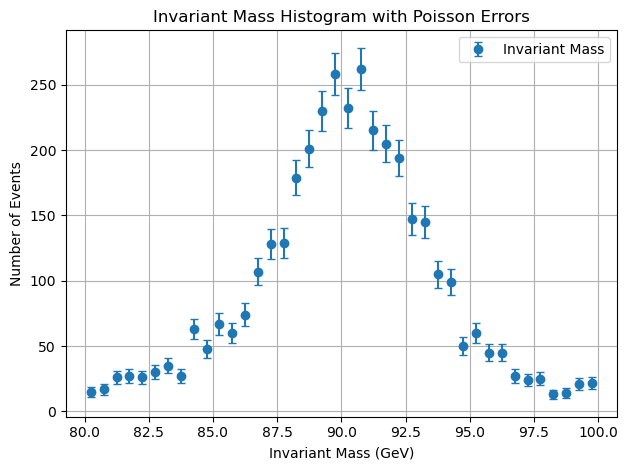

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load invariant masses
df = pd.read_csv("invariant_masses.csv")
mass_values = df['invariant_mass']

# Set histogram binning from 80 to 100 GeV with 41 bins
bins = np.linspace(80, 100, 41)
counts, edges = np.histogram(mass_values, bins=bins)
errors = np.sqrt(counts)

# Bin centers for plotting
bin_centers = (edges[:-1] + edges[1:]) / 2

# Plot
plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', capsize=3, label='Invariant Mass')
plt.xlabel("Invariant Mass (GeV)")
plt.ylabel("Number of Events")
plt.title("Invariant Mass Histogram with Poisson Errors")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
import numpy as np

def breit_wigner(m, m0, Gamma):
    """
    Compute the Breit-Wigner distribution.

    Parameters:
    - m: Mass values (array-like)
    - m0: Central mass (peak position)
    - Gamma: Width (full width at half maximum)

    Returns:
    - Breit-Wigner probability density values
    """
    numerator = Gamma / 2
    denominator = (m - m0)**2 + (Gamma / 2)**2
    return (1 / np.pi) * (numerator / denominator)


In [27]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Reload histogram data
file_path = '/mnt/data/atlas_z_to_ll.csv'
df = pd.read_csv(r"C:\Users\Owner\Downloads\atlas_z_to_ll.csv")

# Redefine helper functions for invariant mass calculation
def calculate_components(pt, eta, phi):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    return px, py, pz

def calculate_invariant_mass(E, px, py, pz):
    return np.sqrt(np.maximum(E**2 - (px**2 + py**2 + pz**2), 0))

# Compute 4-momentum components
px1, py1, pz1 = calculate_components(df['pt1'], df['eta1'], df['phi1'])
px2, py2, pz2 = calculate_components(df['pt2'], df['eta2'], df['phi2'])

E_total = df['E1'] + df['E2']
px_total = px1 + px2
py_total = py1 + py2
pz_total = pz1 + pz2

# Compute invariant mass
df['invariant_mass'] = calculate_invariant_mass(E_total, px_total, py_total, pz_total)
mass_values = df['invariant_mass']

# Create histogram
mass_bins = np.linspace(80, 100, 41)
counts, bin_edges = np.histogram(mass_values, bins=mass_bins)
errors = np.sqrt(counts)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


# Define the Brei\t-Wigner fit function
def breit_wigner_scaled(m, m0, Gamma, scale):
    numerator = Gamma / 2
    denominator = (m - m0)**2 + (Gamma / 2)**2
    return scale * (1 / np.pi) * (numerator / denominator)

# Fit in the range 87 < m < 93 GeV
mask = (bin_centers > 87) & (bin_centers < 93)

# Fit the data
popt, pcov = curve_fit(
    breit_wigner_scaled,
    bin_centers[mask],
    counts[mask],
    sigma=errors[mask],
    absolute_sigma=True,
    p0=[91.2, 2.5, 2500]
)

# Extract fit parameters
m0_fit, Gamma_fit, scale_fit = popt
m0_fit, Gamma_fit, scale_fit


(np.float64(90.31385410549431),
 np.float64(5.964584230739665),
 np.float64(2368.8498044907506))

In [28]:
# fitted mass will be 90 GeV, fitted width 5.96 Gev, scale factor will be 2368 GeV

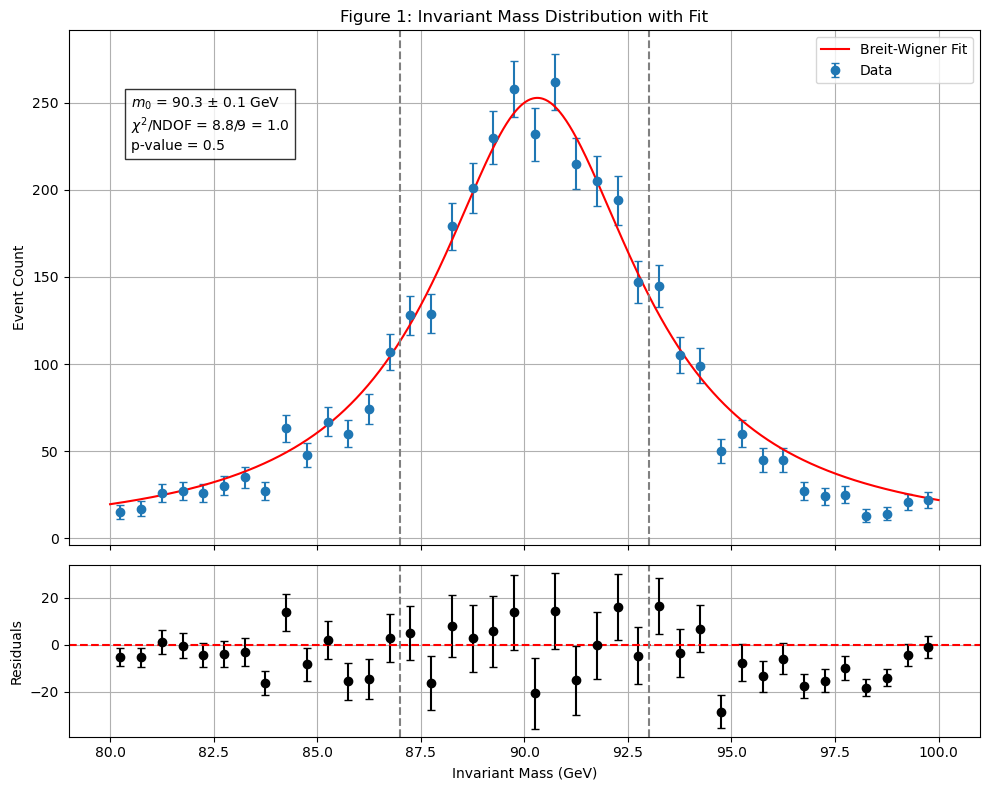

In [29]:
from scipy.stats import chi2

x_fit = bin_centers[mask]
y_fit = counts[mask]
yerr_fit = errors[mask]
fit_vals = breit_wigner_scaled(x_fit, *popt)

chi_square = np.sum(((y_fit - fit_vals) / yerr_fit) ** 2)
ndof = len(x_fit) - len(popt)
reduced_chi_square = chi_square / ndof
p_value = 1 - chi2.cdf(chi_square, ndof)

perr = np.sqrt(np.diag(pcov))
m0_uncertainty = perr[0]
Gamma_uncertainty = perr[1]

# Format annotation values
annotation_text = (
    f"$m_0$ = {m0_fit:.1f} ± {m0_uncertainty:.1f} GeV\n"
    f"$\\chi^2$/NDOF = {chi_square:.1f}/{ndof} = {reduced_chi_square:.1f}\n"
    f"p-value = {p_value:.1f}"
)

# Add annotation to top plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax1.errorbar(bin_centers, counts, yerr=errors, fmt='o', label='Data', capsize=3)
ax1.plot(m_plot, fit_curve, color='red', label='Breit-Wigner Fit')
ax1.axvline(87, color='gray', linestyle='--')
ax1.axvline(93, color='gray', linestyle='--')
ax1.set_ylabel("Event Count")
ax1.set_title("Figure 1: Invariant Mass Distribution with Fit")
ax1.text(80.5, max(counts)*0.85, annotation_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
ax1.legend()
ax1.grid(True)

# Residuals
ax2.errorbar(bin_centers, residuals, yerr=errors, fmt='o', color='black', capsize=3)
ax2.axhline(0, color='red', linestyle='--')
ax2.axvline(87, color='gray', linestyle='--')
ax2.axvline(93, color='gray', linestyle='--')
ax2.set_xlabel("Invariant Mass (GeV)")
ax2.set_ylabel("Residuals")
ax2.grid(True)

plt.tight_layout()
plt.show()



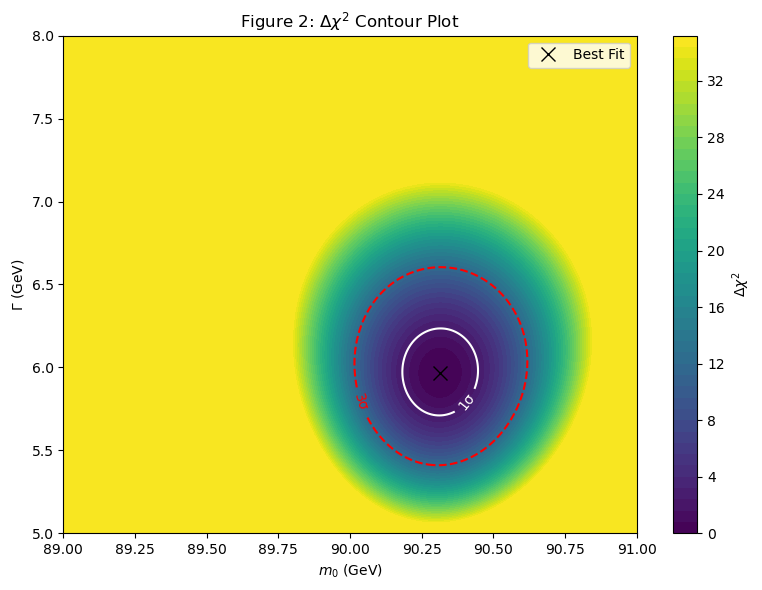

In [30]:
# Grid scan ranges
mass_grid = np.linspace(89, 91, 300)
width_grid = np.linspace(5, 8, 300)

# Create 2D mesh grid
M0, Gamma = np.meshgrid(mass_grid, width_grid)

# Calculate chi-square for each (m0, Gamma) pair
chi2_grid = np.zeros_like(M0)

for i in range(M0.shape[0]):
    for j in range(M0.shape[1]):
        model = breit_wigner_scaled(x_fit, M0[i, j], Gamma[i, j], scale_fit)
        chi2_grid[i, j] = np.sum(((y_fit - model) / yerr_fit) ** 2)

# Find minimum chi-square
chi2_min = np.min(chi2_grid)

# Δχ² map
delta_chi2 = chi2_grid - chi2_min

# Clip Δχ² values above 35
delta_chi2_clipped = np.clip(delta_chi2, 0, 35)

# Make contour plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(M0, Gamma, delta_chi2_clipped, levels=50, cmap='viridis')
cbar = fig.colorbar(contour)
cbar.set_label(r'$\Delta \chi^2$')
ax.set_xlabel(r'$m_0$ (GeV)')
ax.set_ylabel(r'$\Gamma$ (GeV)')
ax.set_title(r'Figure 2: $\Delta \chi^2$ Contour Plot')

# Confidence level contours
CS = ax.contour(M0, Gamma, delta_chi2, levels=[2.30, 11.83], colors=['white', 'red'], linestyles=['solid', 'dashed'])
ax.clabel(CS, inline=True, fontsize=10, fmt={2.30: '1σ', 11.83: '3σ'})

# Overlay best-fit marker
ax.plot(m0_fit, Gamma_fit, 'kx', markersize=10, label='Best Fit')
ax.legend()
plt.tight_layout()
plt.show()
